# Spectral analysis with Gammapy

## Introduction

This notebook explains how to use the functions and classes in [gammapy.spectrum](http://docs.gammapy.org/en/latest/spectrum/index.html).

Based on a datasets of 4 Crab observations with H.E.S.S. (simulated events for now) we will perform a full region based spectral analysis, i.e. extracting source and background counts from certain 
regions, and fitting them using the forward-folding approach.

Data handling:

* [gammapy.data.DataStore](http://docs.gammapy.org/en/latest/api/gammapy.data.DataStore.html)
* [gammapy.data.DataStoreObservation](http://docs.gammapy.org/en/latest/api/gammapy.data.DataStoreObservation.html)
* [gammapy.data.Target](http://docs.gammapy.org/en/latest/api/gammapy.data.Target.html)
* [gammapy.data.ObservationStats](http://docs.gammapy.org/en/latest/api/gammapy.data.ObservationStats.html)
* [gammapy.data.ObservationSummary](http://docs.gammapy.org/en/latest/api/gammapy.data.ObservationSummary.html)

To extract the 1-dim spectral information:

* [gammapy.spectrum.SpectrumObservation](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.SpectrumObservation.html)
* [gammapy.spectrum.SpectrumExtraction](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.SpectrumExtraction.html)
* [gammapy.background.ReflectedRegionsBackgroundEstimator](http://docs.gammapy.org/en/latest/api/gammapy.background.ReflectedRegionsBackgroundEstimator.html)


For the global fit (using Sherpa and WSTAT in the background):

* [gammapy.spectrum.SpectrumFit](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.SpectrumFit.html)
* [gammapy.spectrum.models.PowerLaw](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.models.PowerLaw.html)
* [gammapy.spectrum.models.ExponentialCutoffPowerLaw](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.models.ExponentialCutoffPowerLaw.html)
* [gammapy.spectrum.models.LogParabola](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.models.LogParabola.html)

To compute flux points (a.k.a. "SED" = "spectral energy distribution")

* [gammapy.spectrum.SpectrumResult](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.SpectrumResult.html)
* [gammapy.spectrum.FluxPoints](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.FluxPoints.html)
* [gammapy.spectrum.SpectrumEnergyGroupMaker](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.SpectrumEnergyGroupMaker.html)
* [gammapy.spectrum.FluxPointEstimator](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.FluxPointEstimator.html)

We know this is a lot of classes and complexity.
The reason is that we have created Gammapy as a flexible, modular toolbox to implement such analyses.

We will add more high-level classes and command line tools that execute the common workflows like the one done here by hand as a pipeline and output a nice summary, to make the common cases easy.

Feedback welcome!

## Setup

As usual, we'll start with some setup ...

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
# units and coordinates from astropy
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle

# Regions 
from regions import CircleSkyRegion

# Datastore is the interface to the index of observations 
from gammapy.data import Target
from gammapy.data import DataStore, ObservationList
from gammapy.data import ObservationStats, ObservationSummary

# The background method
from gammapy.background.reflected import ReflectedRegionsBackgroundEstimator

# Some utility function to deal with energy axis (log binning with a unit etc)
from gammapy.utils.energy import EnergyBounds

# The class performing the extraction and extraction results
from gammapy.spectrum import SpectrumExtraction, SpectrumObservation, SpectrumFit, SpectrumResult

# Spectral models
from gammapy.spectrum.models import PowerLaw, ExponentialCutoffPowerLaw, LogParabola
# Utilities for flux points plotting
from gammapy.spectrum import FluxPoints, SpectrumEnergyGroupMaker, FluxPointEstimator

# A class to deal with exclusion regions
from gammapy.image import SkyMask

from gammapy.extern.pathlib import Path


## Load Data

First, we select and load some H.E.S.S. observations of the Crab nebula (simulated events for now).

We will access the events, effective area, energy dispersion, livetime and PSF for containement correction.

In [3]:
DATA_DIR = '$GAMMAPY_EXTRA/datasets/hess-crab4-hd-hap-prod2'

datastore = DataStore.from_dir(DATA_DIR)
obs_ids = [23523, 23526, 23559, 23592]

observations = ObservationList(datastore.obs(obs_id) for obs_id in obs_ids)
print(observations[0])

Info for OBS_ID = 23523
- Start time: 53343.92
- Pointing pos: RA 83.63 deg / Dec 21.51 deg
- Observation duration: 1687.0 s
- Dead-time fraction: 6.240 %



## Define Target Region

The next step is to define a signal extraction region, also known as on region. In the simplest case this is just a [CircleSkyRegion](http://astropy-regions.readthedocs.io/en/latest/api/regions.CircleSkyRegion.html#regions.CircleSkyRegion), but here we will use the ``Target`` class in gammapy that is useful for book-keeping if you run several analysis in a script.

In [4]:
target_position = SkyCoord(ra=83.63, dec=22.01, unit='deg', frame='icrs')
on_region_radius = Angle('0.11 deg')
on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)

target = Target(on_region=on_region, name='Crab', tag='crab_example')
# print(target)

## Load exclusion mask

Most analysis will require a mask to exclude regions with possible gamma-ray signal from the background estimation procedure. For simplicity, we will use a pre-cooked exclusion mask from gammapy-extra which includes (or rather excludes) all source listed in the [TeVCat](http://tevcat.uchicago.edu/) and cutout only the region around the crab.

TODO: Change to [gamma-cat](https://gammapy.github.io/gamma-cat/)

In [5]:
EXCLUSION_FILE = '$GAMMAPY_EXTRA/datasets/exclusion_masks/tevcat_exclusion.fits'

allsky_mask = SkyMask.read(EXCLUSION_FILE)
exclusion_mask = allsky_mask.cutout(
    position=target.on_region.center,
    size=Angle('6 deg'),
)

## Estimate background

Next we will manually perform a background estimate by placing [reflected regions](http://docs.gammapy.org/en/latest/background/reflected.html) around the pointing position and looking at the source statistics. In a real analysis you probably don't want to this every time. In this case you can also pass the background estimation parameters directly to the ``SpectrumExtraction`` class, as shown below in [Extract Spectrum](#extract_spectrum).

In [6]:
background_estimator = ReflectedRegionsBackgroundEstimator(
    on_region=target.on_region,
    obs_list = observations,
    exclusion = exclusion_mask)

background_estimator.run()
bkg = background_estimator.result

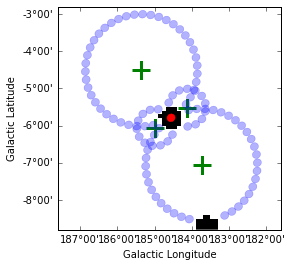

In [7]:
fig, ax, cbar = exclusion_mask.plot()
target.on_region.plot(ax=ax, color='red')

# without this the axis limits are changed when calling scatter
ax.autoscale(enable=False)

for obs_index, obs in enumerate(observations):
    test_pointing = obs.pointing_radec


    ax.scatter(test_pointing.galactic.l, test_pointing.galactic.b,
               transform=ax.get_transform('galactic'),
               marker='+', color='green', s=300, linewidths=3)

    for off in bkg[obs_index].off_region:
        off.plot(ax=ax,alpha=0.3,color='blue')
    

## Source statistic

Next we're going to look at the overall source statistics in our signal region. For more info about what debug plots you can create check out the [ObservationSummary](http://docs.gammapy.org/en/latest/api/gammapy.data.ObservationSummary.html#gammapy.data.ObservationSummary) class.

*** Observation summary report ***
Observation Id: 23526
Livetime: 0.437 h
On events: 168
Off events: 58
Alpha: 0.091
Bkg events in On region: 5.27
Excess: 162.73
Excess / Background: 30.86
Gamma rate: 6.41 1 / min
Bkg rate: 0.20 1 / min
Sigma: 24.24



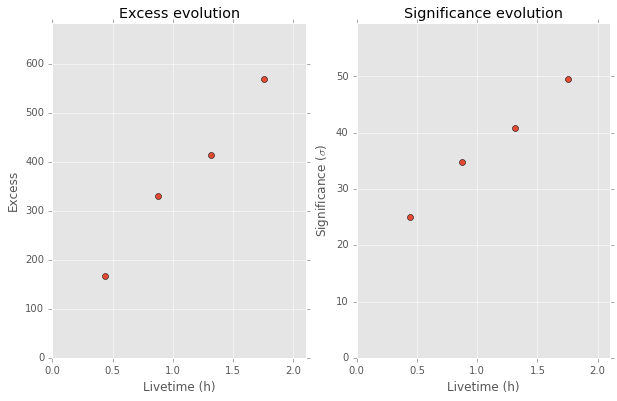

In [8]:
stats = []
for _obs, _bkg in zip(observations, bkg):
    stats.append(ObservationStats.from_target(_obs, target, _bkg))
    
print(stats[1])
obs_summary = ObservationSummary(stats)
fig = plt.figure(figsize=(10,6))
ax1=fig.add_subplot(121)
obs_summary.plot_excess_vs_livetime(ax=ax1)
ax2=fig.add_subplot(122)
obs_summary.plot_significance_vs_livetime(ax=ax2)



## Extract spectrum

<a id='extract_spectrum'></a>

Finally, we're going to extract a spectrum using the [SpectrumExtraction](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.SpectrumExtraction.html) class. Since most of the time you probably want to go directly to this step, we'll assume you just defined all your input data, but not performed any background estimation. Therefore you have to pass the background estimation parameters as a dict to the ``SpectrumExtraction`` instance. The ``run`` method executes all steps of the extraction process and saves the results in the folder ``ANALYSIS_DIR``.

### Define energy binning

We now provide the reconstructed energy binning we want to use. It is expected to be a Quantity with unit energy, i.e. an array with an energy unit. We use a utility function to create it.

We also provide the true energy binning to use instead of default value.

In [9]:
### Define reco energy binning
e_reco = EnergyBounds.equal_log_spacing(0.1, 40, 40, unit='TeV')

### Define True energy binning
e_true = EnergyBounds.equal_log_spacing(0.05, 100., 200, unit='TeV')

### Perform the spectral extraction

Instantiate the required object and do the extraction. 
We also compute a threshold energy and store the result in OGIP compliant files (pha, rmf, arf). This last step might be omitted though.

In [10]:
ANALYSIS_DIR = 'crab_analysis'

bkg_estimation = dict(
    method='reflected',
    exclusion=exclusion_mask
)

extraction = SpectrumExtraction(target=target,
                                obs=observations,
                                background=bkg_estimation)
extraction.run()

In [11]:
### Write output in the form of OGIP files: PHA, ARF, RMF, BKG
extraction.observations.write(outdir=ANALYSIS_DIR+'/ogip_data/', use_sherpa=True)



## Look at observations

At this point we could proceed and fit a global model to the spectrum we just extraced. However, we will take a short moment to have a look at the files we just created. The ``crab_analysis`` directory contains a folder called ``ogip_data``. In this folder you find 4 ``FITS`` files for each observation. These files are described in detail at https://gamma-astro-data-formats.readthedocs.io/en/latest/ogip/index.html. In short they correspond to the on vector, the off vector, the effectie area, and the energy dispersion.

In [ ]:
filename = ANALYSIS_DIR + '/ogip_data/pha_obs23523.fits'
obs = SpectrumObservation.read(filename)
obs.peek()

## Fit spectrum

Now we'll fit a global model to the spectrum. First we do a joint likelihood fit to all observations. If you want to stack the observations see below. We will also produce a debug plot in order to show how the global fit matches one of the individual observations.


Fit result info 
--------------- 
Model: PowerLaw
ParameterList
Parameter(name=u'index', value=2.173663379564313+/-0.044800361071267815, unit='', min=0, max=None, frozen=False)
Parameter(name=u'amplitude', value=1.9855364695463224e-11+/-1.0001348872251992e-12, unit='', min=0, max=None, frozen=False)
Parameter(name=u'reference', value=1.0, unit='', min=None, max=None, frozen=True)
Covariance: None 

Statistic: 34.459 (wstat)
Covariance:
[u'index', u'amplitude']
[[  2.00707235e-03   2.13642869e-14]
 [  2.13642869e-14   1.00026979e-24]]
Fit Range: [  6.81292069e+08   1.00000000e+11] keV



/Users/terrier/Code/gammapy/gammapy/build/lib.macosx-10.5-x86_64-2.7/gammapy/stats/fit_statistics.py:161: RuntimeWarning: divide by zero encountered in log
  term2_ = - n_on * np.log(mu_sig + alpha * mu_bkg)
/Users/terrier/Code/gammapy/gammapy/build/lib.macosx-10.5-x86_64-2.7/gammapy/stats/fit_statistics.py:166: RuntimeWarning: divide by zero encountered in log
  term3_ = - n_off * np.log(mu_bkg)
/Users/terrier/Code/gammapy/gammapy/build/lib.macosx-10.5-x86_64-2.7/gammapy/stats/fit_statistics.py:198: RuntimeWarning: divide by zero encountered in log
  term1 = - n_on * (1 - np.log(n_on))
/Users/terrier/Code/gammapy/gammapy/build/lib.macosx-10.5-x86_64-2.7/gammapy/stats/fit_statistics.py:199: RuntimeWarning: divide by zero encountered in log
  term2 = - n_off * (1 - np.log(n_off))


(<matplotlib.axes._subplots.AxesSubplot at 0x1163df110>,
 <matplotlib.axes._subplots.AxesSubplot at 0x116678450>)

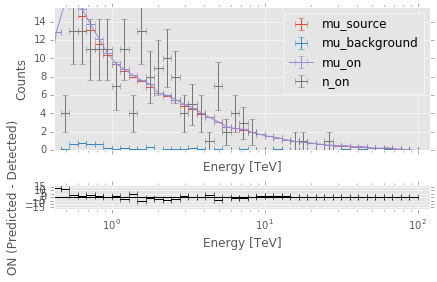

In [12]:
model = PowerLaw(index = 2 * u.Unit(''),
                amplitude = 2e-11 * u.Unit('cm-2 s-1 TeV-1'),
                reference = 1 * u.TeV)

fit = SpectrumFit(extraction.observations, model)
fit.run(outdir = ANALYSIS_DIR)

print(fit.result[0])
fit.result[1].plot()

## Compute Flux Points

To round up out analysis we can compute flux points by fitting the norm of the global model in energy bands. To get a sensible energy binning we require a 4 sigma detection in each energy band.

In [13]:
ebounds = [0.3, 1.1, 3, 10.1, 30] * u.TeV
stacked_obs = extraction.observations.stack()

#Temporary fix - remove one SpectrumEnergyGroupMaker uses quality vector correctly
stacked_obs.hi_threshold = 80 * u.TeV
seg = SpectrumEnergyGroupMaker(obs=stacked_obs)
seg.compute_range_safe()
seg.compute_groups_fixed(ebounds=ebounds)

print(seg)
print(seg.groups)

SpectrumEnergyGroupMaker:

Spectrum table:
Number of bins: 72
Bin range: (0, 71)
Energy range: EnergyRange(min=10000000.0 keV, max=1e+11 keV)
SpectrumEnergyGroups:

Info including underflow- and overflow bins:
Number of groups: 6
Bin range: (0, 71)
Energy range: EnergyRange(min=10000000.0 keV, max=1e+11 keV)

SpectrumEnergyGroups:

Info including underflow- and overflow bins:
Number of groups: 6
Bin range: (0, 71)
Energy range: EnergyRange(min=10000000.0 keV, max=1e+11 keV)



/Users/terrier/Code/gammapy/gammapy/build/lib.macosx-10.5-x86_64-2.7/gammapy/stats/poisson.py:383: RuntimeWarning: divide by zero encountered in double_scalars
  temp = (alpha + 1) / (n_on + n_off)
/Users/terrier/Code/gammapy/gammapy/build/lib.macosx-10.5-x86_64-2.7/gammapy/stats/poisson.py:385: RuntimeWarning: divide by zero encountered in log
  m = n_off * log(n_off * temp)
/Users/terrier/Code/gammapy/gammapy/build/lib.macosx-10.5-x86_64-2.7/gammapy/stats/poisson.py:384: RuntimeWarning: divide by zero encountered in log
  l = n_on * log(n_on * temp / alpha)


In [14]:
fpe = FluxPointEstimator(
    obs=obs,
    groups=seg.groups,
    model=fit.model,
)
fpe.compute_points()


print(fpe.flux_points)
# Have to set flux unit here because flux points default unit is ph / ... which raises a unit conversion error
fpe.flux_points.plot(flux_unit = 'cm-2 s-1 TeV-1')

ValueError: Invalid input for parameter obs_list

In [ ]:
spectrum_result = SpectrumResult(
    points=fpe.flux_points,
    fit=fit.result[0],
)

spectrum_result.plot(
    energy_range=fit.result[0].fit_range,
    energy_power=2, flux_unit='erg-1 cm-2 s-1',
)

## Stack observations

And alternative approach to fitting the spectrum is stacking all observations first and the fitting a model to the stacked observation. This works as follows. A comparison to the joint likelihood fit is also printed.

In [ ]:
stacked_obs = extraction.observations.stack()
stacked_fit = SpectrumFit(stacked_obs, model)

stacked_fit.fit()
stacked_fit.est_errors()
print(stacked_fit.result[0])

stacked_table = stacked_fit.result[0].to_table(format='.3g')
stacked_table['method'] = 'stacked'
joint_table = fit.result[0].to_table(format='.3g')
joint_table['method'] = 'joint'
from astropy.table import vstack as vstack_table
print(vstack_table([stacked_table, joint_table])['method', 'index', 'index_err', 'amplitude', 'amplitude_err'])

## Fitting the spectrum with sherpa

Once we have exported the spectral files (PHA, ARF, RMF and BKG) in the OGIP format, it becomes possible to fit them later with gammapy or with any existing OGIP compliant tool such as XSpec or sherpa.

We show here how to do so with sherpa using the high-level user interface. For a general view on how to use stand-alone sherpa, see this [tutorial](http://nbviewer.jupyter.org/github/sherpa/sherpa/blob/master/docs/SherpaQuickStart.ipynb)

### loading the data as a sherpa DataStack

We first need to import the user interface and load the data with [load_data](http://cxc.harvard.edu/sherpa/ahelp/load_data.html). One can load files one by one, or more simply load them all at once through a [DataStack](http://cxc.harvard.edu/sherpa/ahelp/datastack.html).

In [15]:
import glob   # to list files
import sherpa.astro.ui as sh
from sherpa.astro.datastack import DataStack
from sherpa.astro.datastack import load_data, set_source, set_stat, fit, conf, plot_fit, notice, reg_unc

# If we want to load just one file
# sh.load_data(import sherpa.astro.ui as sh



# Otherwise we need to have a text file containing all the names
# and load it with ds.load_data(@myfile)
ds = DataStack()
pha_list = glob.glob(ANALYSIS_DIR + '/ogip_files/pha_obs?????.fits')
for pha in pha_list:
    load_data(ds,pha)

failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find ds9 on your PATH'


failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find ds9 on your PATH'


read ARF file crab_analysis/ogip_files/arf_obs23523.fits


INFO:sherpa.astro.io:read ARF file crab_analysis/ogip_files/arf_obs23523.fits


read RMF file crab_analysis/ogip_files/rmf_obs23523.fits


INFO:sherpa.astro.io:read RMF file crab_analysis/ogip_files/rmf_obs23523.fits


read background file crab_analysis/ogip_files/bkg_obs23523.fits


INFO:sherpa.astro.io:read background file crab_analysis/ogip_files/bkg_obs23523.fits


read ARF file crab_analysis/ogip_files/arf_obs23526.fits


INFO:sherpa.astro.io:read ARF file crab_analysis/ogip_files/arf_obs23526.fits


read RMF file crab_analysis/ogip_files/rmf_obs23526.fits


INFO:sherpa.astro.io:read RMF file crab_analysis/ogip_files/rmf_obs23526.fits


read background file crab_analysis/ogip_files/bkg_obs23526.fits


INFO:sherpa.astro.io:read background file crab_analysis/ogip_files/bkg_obs23526.fits


read ARF file crab_analysis/ogip_files/arf_obs23559.fits


INFO:sherpa.astro.io:read ARF file crab_analysis/ogip_files/arf_obs23559.fits


read RMF file crab_analysis/ogip_files/rmf_obs23559.fits


INFO:sherpa.astro.io:read RMF file crab_analysis/ogip_files/rmf_obs23559.fits


read background file crab_analysis/ogip_files/bkg_obs23559.fits


INFO:sherpa.astro.io:read background file crab_analysis/ogip_files/bkg_obs23559.fits


read ARF file crab_analysis/ogip_files/arf_obs23592.fits


INFO:sherpa.astro.io:read ARF file crab_analysis/ogip_files/arf_obs23592.fits


read RMF file crab_analysis/ogip_files/rmf_obs23592.fits


INFO:sherpa.astro.io:read RMF file crab_analysis/ogip_files/rmf_obs23592.fits


read background file crab_analysis/ogip_files/bkg_obs23592.fits


INFO:sherpa.astro.io:read background file crab_analysis/ogip_files/bkg_obs23592.fits


### Creating the source model

We can now use sherpa models. We need to remember that they were designed for X-ray astronomy and energy is written in keV. 

Here we start with a simple PL.

In [16]:
# Define the source model
set_source("powlaw1d.p1")

# Change reference energy of the model 
p1.ref = 1e9   # 1 TeV = 1e9 keV
p1.gamma = 2.0
p1.ampl = 1e-20  # in cm**-2 s**-1 keV**-1
# View parameters 
print(p1)


powlaw1d.p1
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   p1.gamma     thawed            2          -10           10           
   p1.ref       frozen        1e+09 -3.40282e+38  3.40282e+38           
   p1.ampl      thawed        1e-20            0  3.40282e+38           


### Perform the fit and compute errors

We need to set the correct statistic: WSTAT.

In [17]:
### Define the statistic
set_stat("WStat")

### Define the fit range
notice(0.6e9,20e9)

### Do the fit
fit()

Dataset               = 1
Method                = levmar
Statistic             = wstat
Initial fit statistic = 61.2483
Final fit statistic   = 29.7562 at function evaluation 195
Data points           = 28
Degrees of freedom    = 26
Probability [Q-value] = 0.277834
Reduced statistic     = 1.14447
Change in statistic   = 31.4921
   p1.gamma       2.16927     
   p1.ampl        1.81488e-20 


INFO:sherpa.astro.ui.utils:Dataset               = 1
Method                = levmar
Statistic             = wstat
Initial fit statistic = 61.2483
Final fit statistic   = 29.7562 at function evaluation 195
Data points           = 28
Degrees of freedom    = 26
Probability [Q-value] = 0.277834
Reduced statistic     = 1.14447
Change in statistic   = 31.4921
   p1.gamma       2.16927     
   p1.ampl        1.81488e-20 


### Plot the result

Plotting with the stand-alone version is not straightforward because of limited interface to matplotlib.

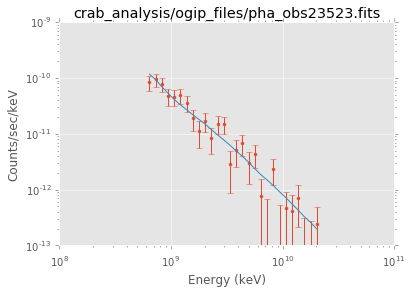

In [18]:
plot_fit()
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")

### Errors and confidence contours


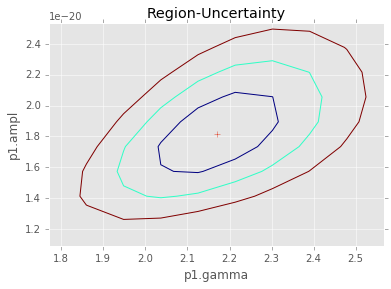

In [19]:
reg_unc(p1.gamma,p1.ampl)

## Exercises

Some things we might do:

- Fit a different spectral model (ECPL or CPL or ...)
- Use different method or parameters to compute the flux points
- Do a chi^2 fit to the flux points and compare

TODO: give pointers how to do this (and maybe write a notebook with solutions)

In [ ]:
# Start the exercises here!

## What next?

In this tutorial we learned ... TODO.

Here's some suggestions where to go next:

* if you interested in available fit statistics checkout [gammapy.stats](docs.gammapy.org/en/latest/stats/index.html?highlight=gammapy.stats)
* if you want to simulate spectral look at [this tutorial](http://docs.gammapy.org/en/latest/spectrum/simulation.html)
* if you want to compare your spectra to e.g. Fermi spectra published in catalogs have a look at [this](http://docs.gammapy.org/en/latest/spectrum/plotting_fermi_spectra.html)